In [85]:
import numpy as np

data = np.loadtxt("input.txt", delimiter=",")

x = data[:, 0]
y = data[:, 1]
print("x\n", x)
print("y\n", y)


x
 [-5.         -4.79591837 -4.59183673 -3.97959184 -3.57142857 -2.95918367
 -2.75510204 -1.73469388 -1.32653061 -0.91836735 -0.71428571 -0.30612245
  0.10204082  0.71428571  1.12244898  1.73469388  1.93877551  2.55102041
  2.95918367  3.97959184  4.3877551   4.59183673  5.        ]
y
 [51.76405235 45.42306433 41.2744481  26.6362165  20.25680606 11.61842924
 10.45052507  1.84809823 -1.04053496 -4.6146308  -1.38719773 -1.9916444
 -0.91292461  6.63482003  9.54686746 15.72016147 20.62251684 33.48059726
 40.76391966 66.89976056 78.44316466 86.99156782 99.78725972]


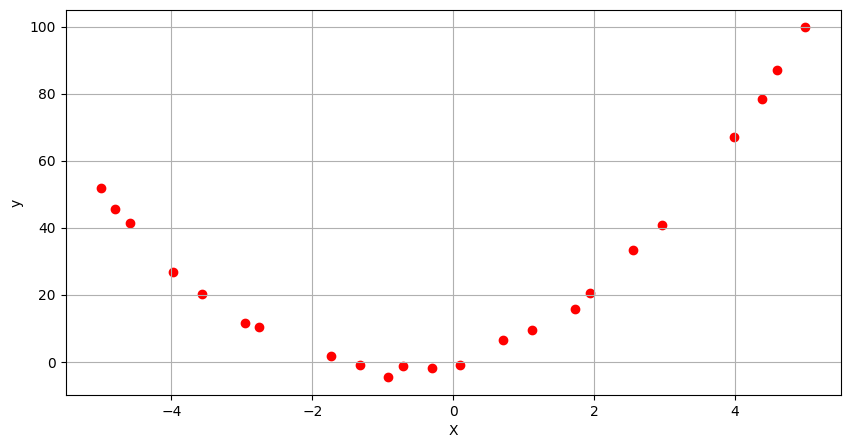

In [86]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(x, y, color="r", label="data")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [87]:
def mat_mult(A, B):

    rows_A = len(A) # 列
    cols_A = len(A[0])
    rows_B = len(B) # 行
    cols_B = len(B[0])

    if cols_A != rows_B:
        raise ValueError("cannot multiply the two matrices. Incorrect dimensions.")

    result = [[0] * cols_B for _ in range(rows_A)]

    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                result[i][j] += A[i][k] * B[k][j]

    return result


def mat_transpose(A): # 轉置矩陣
    rows, cols = len(A), len(A[0])
    return [[A[j][i] for j in range(rows)] for i in range(cols)]


def mat_inverse(A): #  matrix inverse operation => GAUSS-JORDAN ELIMINATION
    n = len(A)

    I = [[1 if i == j else 0 for j in range(n)] for i in range(n)]

    for i in range(n):
        A[i] += I[i]

    for i in range(n):
        diag = A[i][i]
        if diag == 0:
            raise ValueError("Matrix is singular and cannot be inverted")
        for j in range(2 * n):
            A[i][j] /= diag

        for k in range(n):
            if k != i:
                factor = A[k][i]
                for j in range(2 * n):
                    A[k][j] -= factor * A[i][j]

    for i in range(n):
        A[i] = A[i][n:]

    return A


LSE

y = 0.83453x^2 + 0.09315x^1 + 0.04695x^0
Total LSE error: 22649.73849


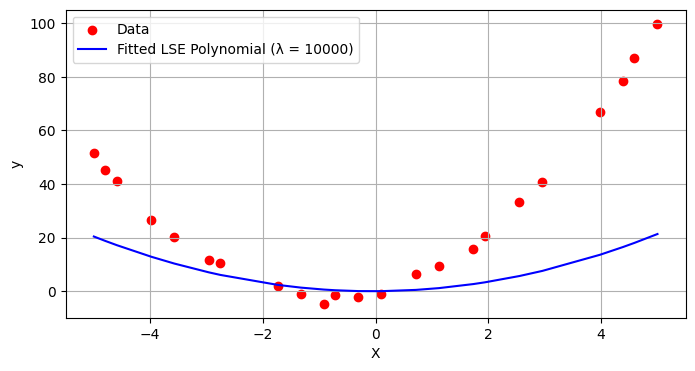

In [88]:
def closed_form_LSE_n_basis(x, y, degree=2, lam=0):

    n = len(x)

    X = [[x[i] ** d for d in range(degree - 1, -1, -1)] for i in range(n)]
    Y = [[y[i]] for i in range(n)]

    # Compute X^T * X
    X_transpose = mat_transpose(X)
    X_transpose_X = mat_mult(X_transpose, X)

    # regularization matrix λI
    dim = len(X_transpose_X)
    lam_I = [[lam if i == j else 0 for j in range(dim)] for i in range(dim)]
    X_T_X_reg = [[X_transpose_X[i][j] + lam_I[i][j] for j in range(dim)] for i in range(dim)]

    # Compute inverse of (X^T * X + λI)
    X_T_X_inv = mat_inverse([row[:] for row in X_T_X_reg])
    X_T_Y = mat_mult(X_transpose, Y)

    w = mat_mult(X_T_X_inv, X_T_Y)

    return [w[i][0] for i in range(len(w))]


degree = 3
lam = 10000
w_poly = closed_form_LSE_n_basis(x, y, degree=degree, lam=lam)

y_pred_poly = [sum(w_poly[j] * (x[i] ** (degree - 1 - j)) for j in range(degree)) for i in range(len(x))]
lse_error_poly = sum((y[i] - y_pred_poly[i])**2 for i in range(len(y)))
equation = "y = " + " + ".join([f"{w_poly[j]:.5f}x^{degree - 1 - j}" for j in range(degree)])
print(equation)
print("Total LSE error: {:.5f}".format(lse_error_poly))

plt.figure(figsize=(8, 4))
plt.scatter(x, y, color="r", label="Data")
plt.plot(x, y_pred_poly, color="b", label="Fitted LSE Polynomial (λ = {})".format(lam))
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


Newton's Method

y = 3.02385x^2 + 4.90619x^1 + -0.23140x^0
Total LSE error : 26.55996


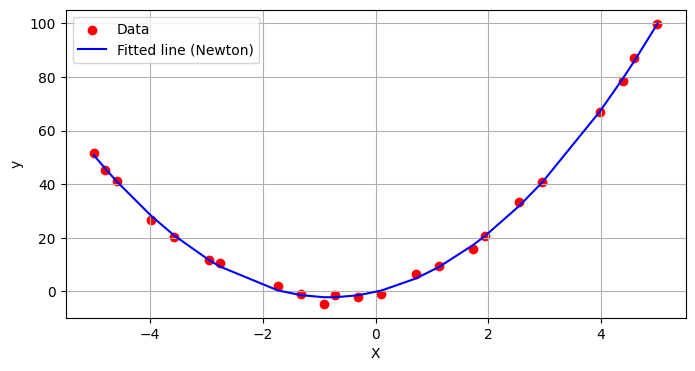

In [89]:
def newtons_method_LSE(x, y, tol=1e-6, max_iters=10, degree=3):
    n = len(x)

    X = [[x[i] ** d for d in range(degree - 1, -1, -1)] for i in range(n)]
    Y = [[y[i]] for i in range(n)]

    w = [[0] for _ in range(degree)]

    for iteration in range(max_iters):
        # Compute gradient g = 2 * X^T * (X w - Y)
        X_T = mat_transpose(X)
        Xw = mat_mult(X, w)
        Xw_minus_Y = [[Xw[i][0] - Y[i][0]] for i in range(n)]
        g = mat_mult(X_T, Xw_minus_Y)
        g = [[2 * g[i][0]] for i in range(len(g))]

        H = mat_mult(X_T, X)
        H = [[2 * H[i][j] for j in range(len(H))] for i in range(len(H))] # Hessian: 2*(X^T * X)

        H_inv = mat_inverse([row[:] for row in H])
        delta_w = mat_mult(H_inv, g)

        # Update weights: w = w - H^(-1) g
        w_new = [[w[i][0] - delta_w[i][0]] for i in range(len(w))]
        diff = sum(abs(w_new[i][0] - w[i][0]) for i in range(len(w)))
        if diff < tol:
            break

        w = w_new

    return [w[i][0] for i in range(degree)]

w = newtons_method_LSE(x, y,degree=degree)

#print(w)


y_pred_newton = [sum(w[j] * (x[i] ** (degree - 1 - j)) for j in range(degree)) for i in range(len(x))]
#print(y_pred_newton)

equation = "y = " + " + ".join([f"{w[j]:.5f}x^{degree - 1 - j}" for j in range(degree)])
print(equation)

lse_error_newton = sum((y[i] - y_pred_newton[i])**2 for i in range(len(y)))
print("Total LSE error : {:.5f}".format(lse_error_newton))


plt.figure(figsize=(8, 4))
plt.scatter(x, y, color="r", label="Data")
plt.plot(x, y_pred_newton, color="b", label="Fitted line (Newton)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


For *steepest descent method*:
1. Use steepest descent with LSE and L1 norm to find the best fitting line.
2. Print out the equation of the best fitting line and the error.
3. [Reference](https://kenndanielso.github.io/mlrefined/blog_posts/13_Multilayer_perceptrons/13_7_General_steepest_descent.html#13.7.1.1--Steepest-descent-direction-in-the-$\ell_2$-norm) (Hint : Consider using a smaller learning rate.)

$$
w^{(k+1)} = w^{(k)} - \frac{\lambda}{|S|} \cdot \text{sign\_grad}
$$


y = 0.00000x^2 + 0.00000x^1 + 0.00000x^0
Total LSE error Steepest Descent Method: 26.55996


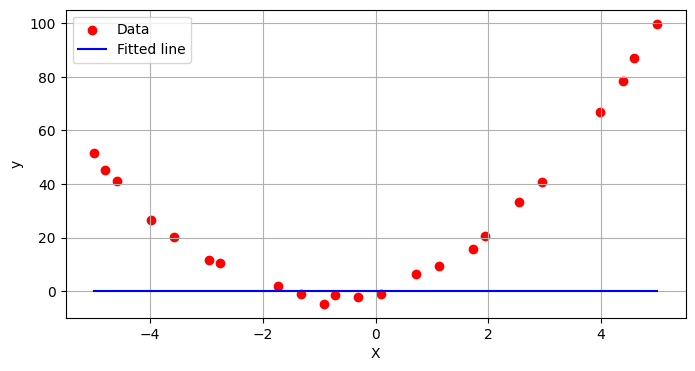

In [90]:
def steepest_descent(x, y, tol=1e-6, max_iters=10000, degree=3, lam=0.01):
    n = len(x)

    X = [[x[i] ** d for d in range(degree - 1, -1, -1)] for i in range(n)]
    Y = [[y[i]] for i in range(n)]

    w = [[0] for _ in range(degree)]

    for iteration in range(max_iters):
        # gradient g = 2 * X^T * (X w - Y)
        X_T = mat_transpose(X)
        Xw = mat_mult(X, w)
        Xw_minus_Y = [[Xw[i][0] - Y[i][0]] for i in range(n)]
        g = mat_mult(X_T, Xw_minus_Y)
        g = [[2 * g[i][0]] for i in range(len(g))]
        # 找出最大絕對值的梯度索引
        max_val = float('-inf')
        S = []
        for i in range(len(g)):
            for j in range(len(g[0])):
                val = abs(g[i][j])
                if val > max_val:
                    max_val = val
                    S = [(i, j)]
                elif val == max_val:
                    S.append((i, j))

        # 計算 sign gradient
        sign_grad = [[0] for i in range(degree)]
        for i, j in S:
            sign_grad[i][j] = g[i][j] / abs(g[i][j])  # 取正負號（±1）
        # 更新權重
        lam = lam # learning = lanbda ???
        w_new = [[w[i][0] - (lam) * sign_grad[i][0]] for i in range(len(w))]

        diff = sum(abs(w_new[i][0] - w[i][0]) for i in range(len(w)))
        if diff < tol:
            break

        w = w_new

    return [w[i][0] for i in range(degree)]

w = steepest_descent(x, y, degree=degree, lam=lam)

# print(w)


y_pred_steepest = [sum(w[j] * (x[i] ** (degree - 1 - j)) for j in range(degree)) for i in range(len(x))]
# print(y_pred_steepest)

equation = "y = " + " + ".join([f"{w[j]:.5f}x^{degree - 1 - j}" for j in range(degree)])
print(equation)

lse_error_steepest = sum((y[i] - y_pred_newton[i])**2 for i in range(len(y)))
print("Total LSE error Steepest Descent Method: {:.5f}".format(lse_error_steepest))


plt.figure(figsize=(8, 4))
plt.scatter(x, y, color="r", label="Data")
plt.plot(x, y_pred_steepest, color="b", label="Fitted line")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
